# Machine Learning Pipeline: Text Classification with Model Selection Focus

## Introduction

In this comprehensive machine learning project, we will work with real text data from the 20 Newsgroups dataset to build an effective text classification system. We have authentic newsgroup posts from four categories (atheism, religion, computer graphics, and medicine) that we'll use to demonstrate a complete ML workflow focused on systematic model selection.

**What We Will Do**: We'll implement four interconnected machine learning tasks: 
- (1) compare baseline text classification models
- (2) use clustering analysis to understand data structure and validate our approach
- (3) engineer domain-specific features to enhance model performance
- (4) apply recursive feature elimination to optimize our final model configuration.

**What We Hope to Achieve**: By the end of this project, we will have developed a data-driven methodology for model selection that balances performance, interpretability, and computational efficiency. Each stage will provide quantitative insights that inform our choices, resulting in a production-ready text classification model with clear justification for every design decision. This systematic approach will demonstrate how multiple ML techniques work together to create robust, well-understood models for real-world applications.


#### Importing libraries

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and dataset loading
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Feature selection
from sklearn.feature_selection import RFE, RFECV

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import silhouette_score

import base64
from IPython.display import display, HTML
import os

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")


#### Notebook utility

In [6]:
image_paths = ["logreg1.png","logreg2.png","svm1.png","svm2.png","svm3.png","nb1.png", "clust1.png","clust2.png","textvect1.webp","textvect2.webp","textvect3.webp","rfe1.webp"]
image_size = [500]*12
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


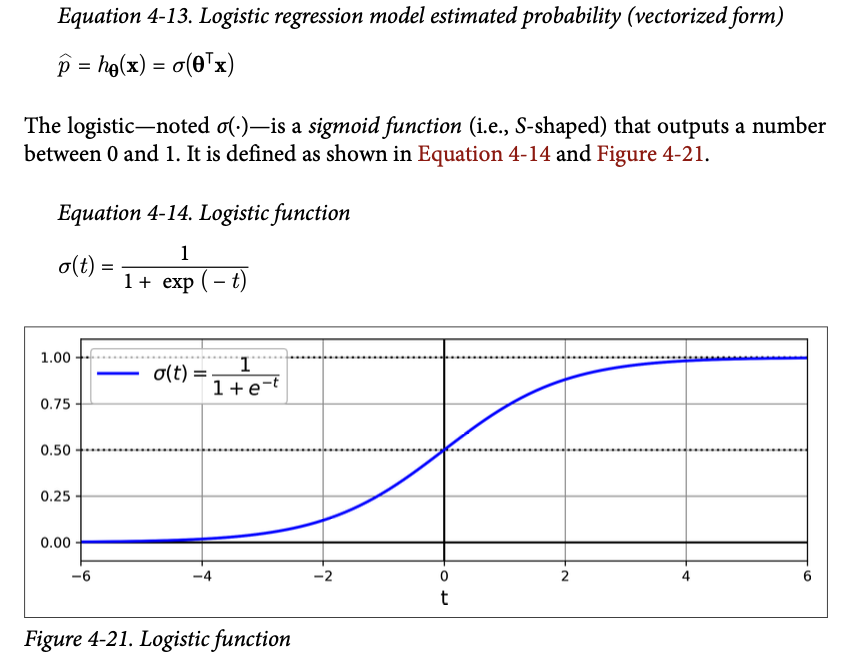

In [7]:
display(HTML(images_html[0]))


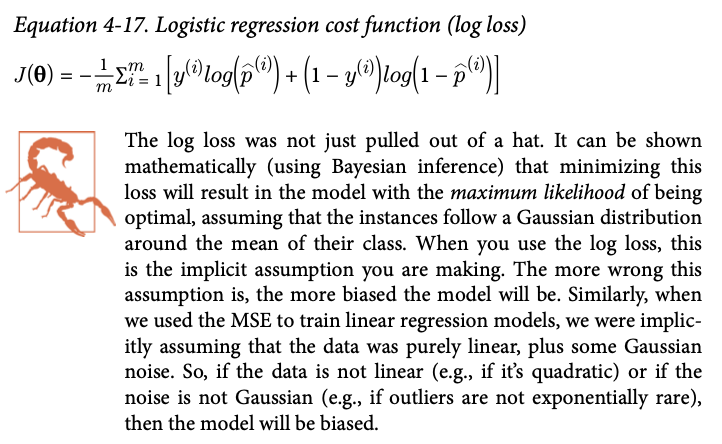

In [8]:
display(HTML(images_html[1]))


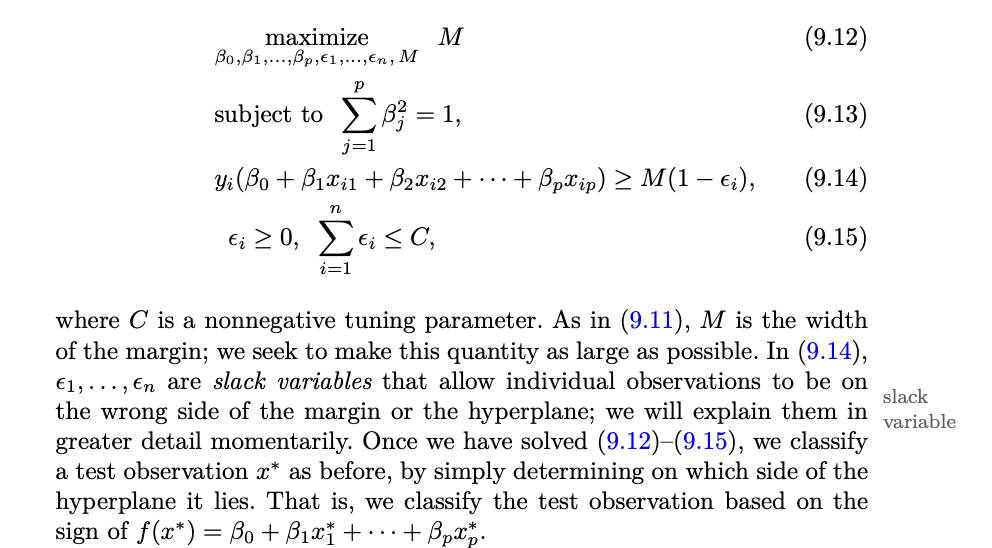

In [9]:
display(HTML(images_html[2]))


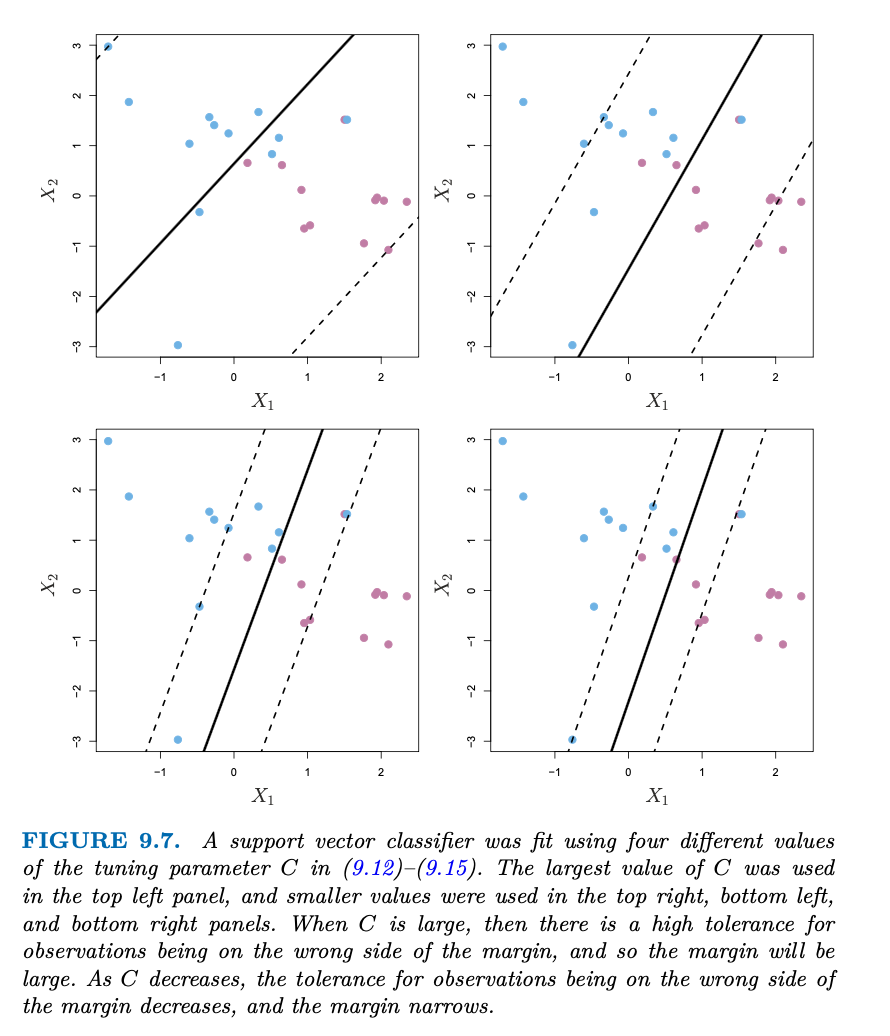

In [10]:
display(HTML(images_html[3]))


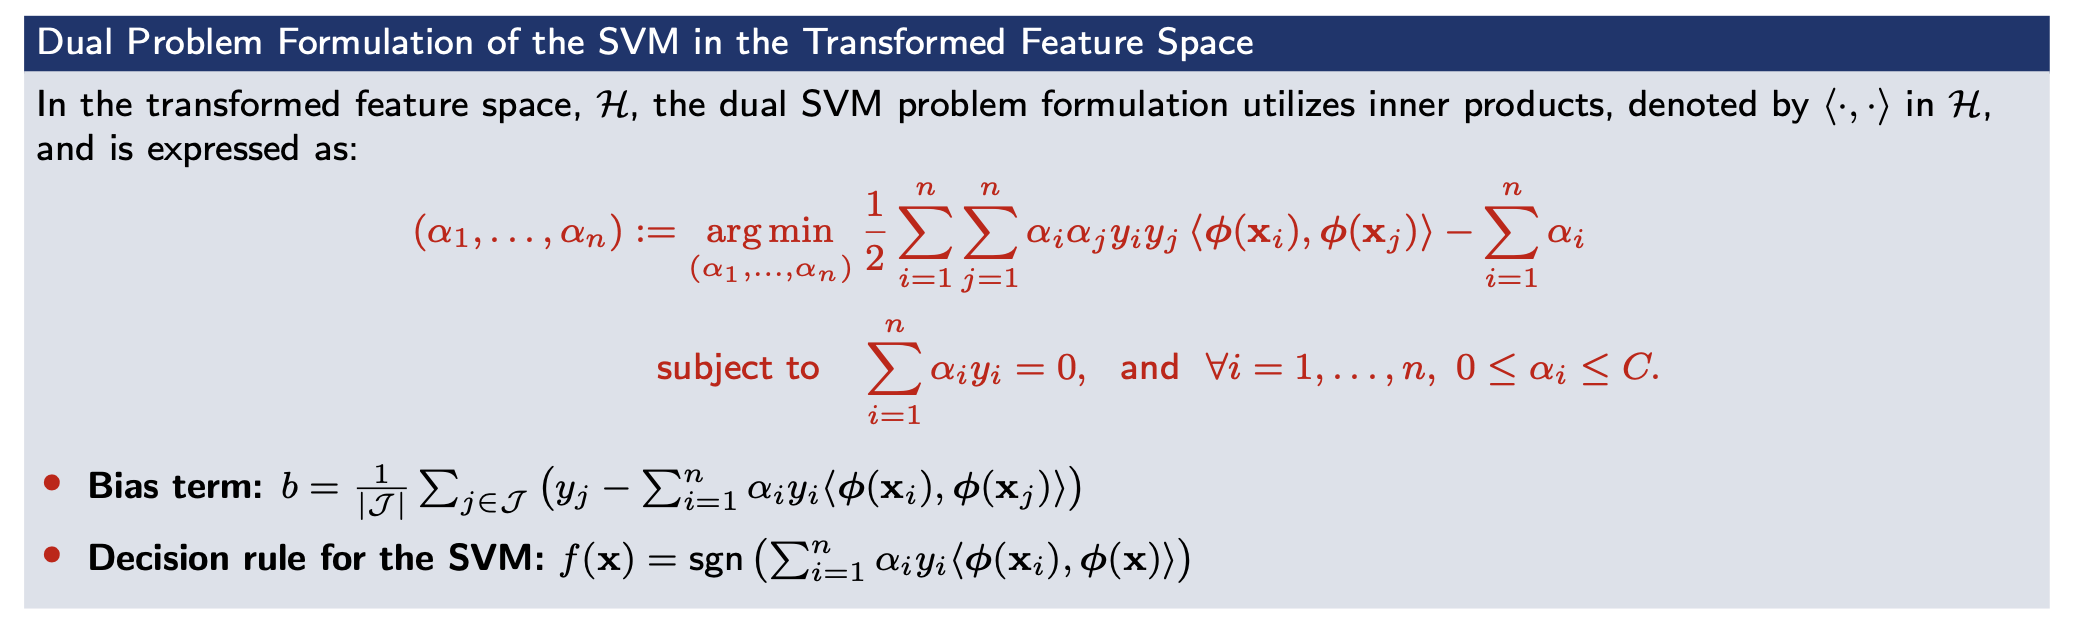

In [11]:
display(HTML(images_html[4]))


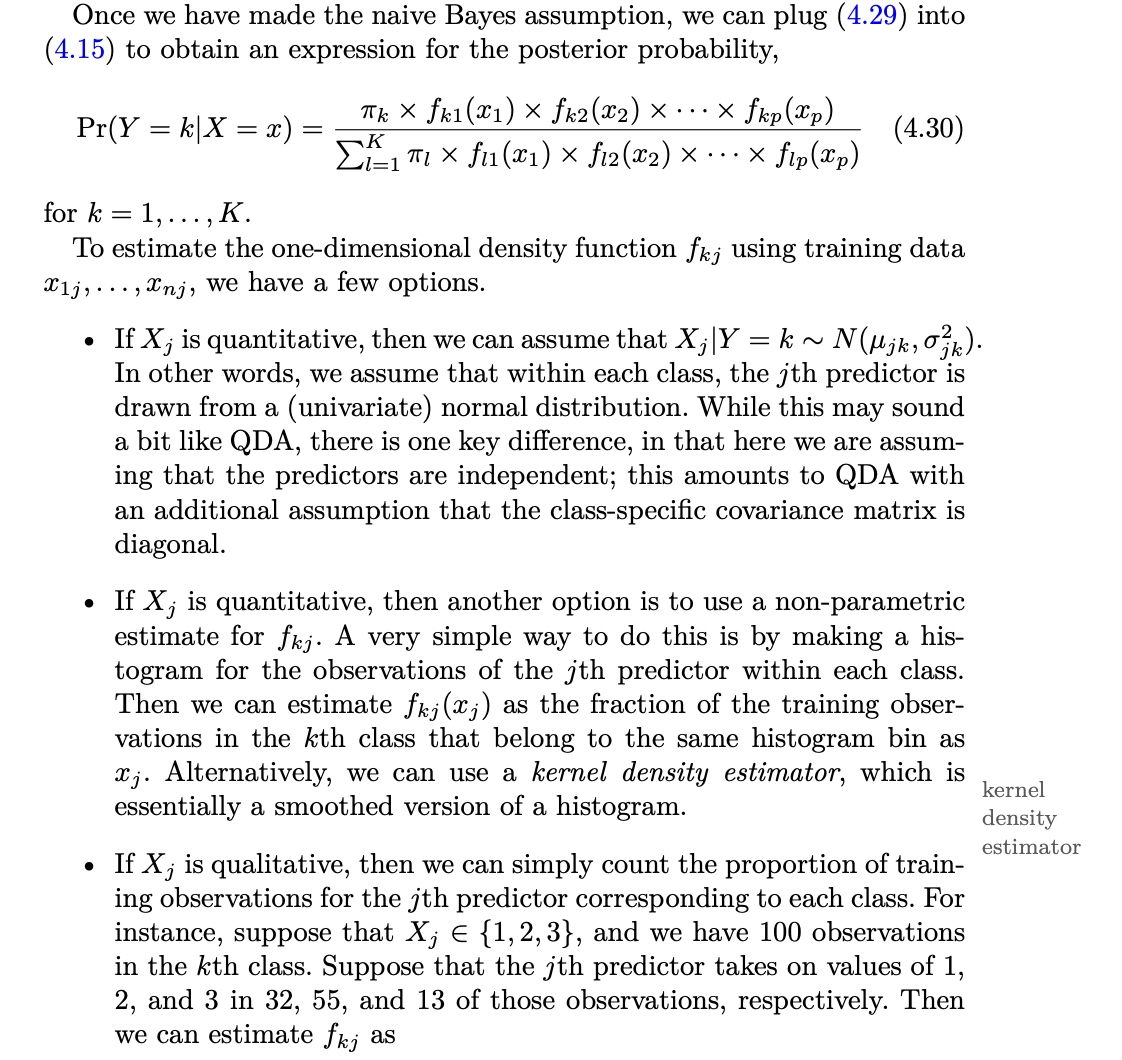

In [12]:
display(HTML(images_html[5]))


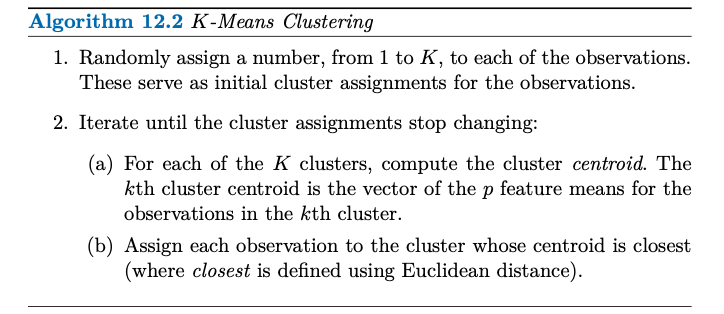

In [13]:
display(HTML(images_html[6]))


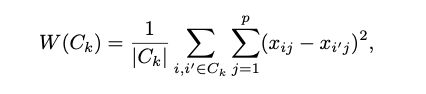

In [14]:
display(HTML(images_html[7]))


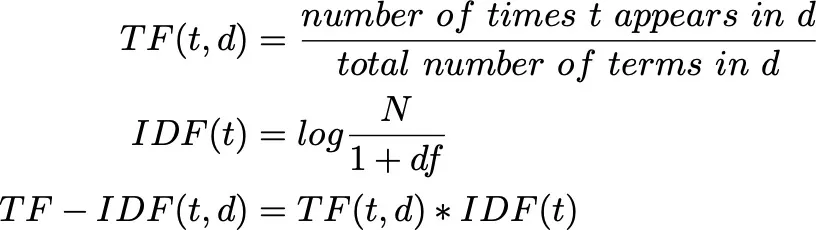

In [15]:
display(HTML(images_html[8]))


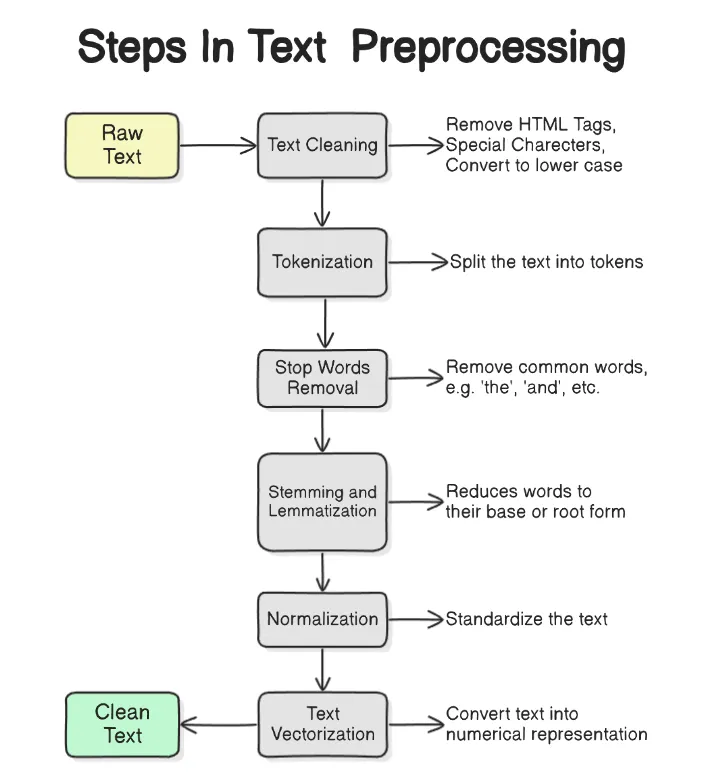

In [17]:
display(HTML(images_html[10]))


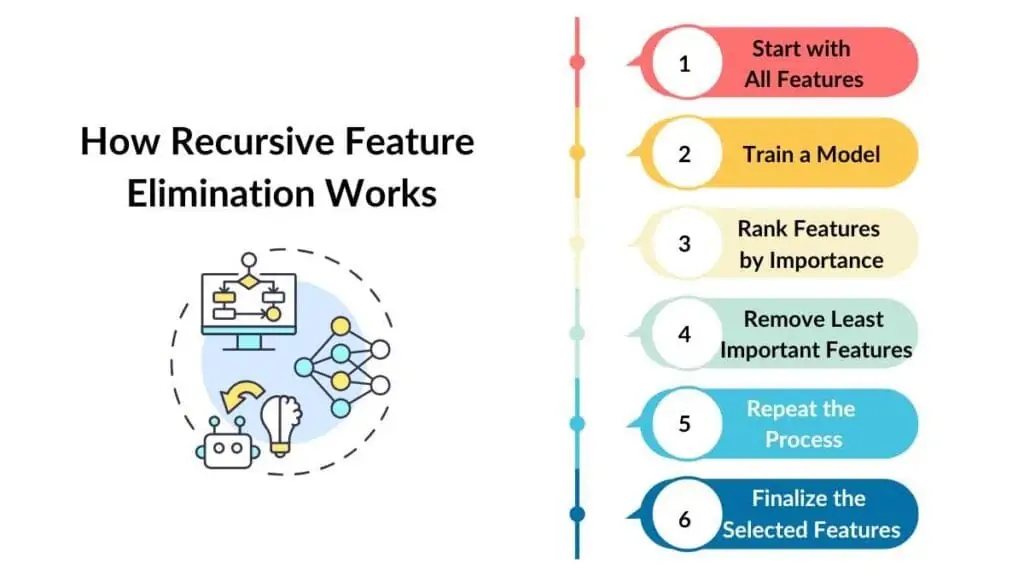

In [18]:
display(HTML(images_html[11]))

#### Load and Explore Data

In [9]:
# Load the 20 Newsgroups dataset
# We'll use 4 categories to create a manageable classification problem
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

print("Loading 20 Newsgroups dataset...")
newsgroups_train = fetch_20newsgroups(
    subset='train', 
    categories=categories, 
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

newsgroups_test = fetch_20newsgroups(
    subset='test', 
    categories=categories, 
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

# Combine train and test for our analysis
all_data = newsgroups_train.data + newsgroups_test.data
all_targets = np.concatenate([newsgroups_train.target, newsgroups_test.target])
all_target_names = newsgroups_train.target_names

print(f"Total samples: {len(all_data)}")
print(f"Categories: {all_target_names}")

# Create DataFrame
df = pd.DataFrame({
    'review_text': all_data,
    'category': [all_target_names[i] for i in all_targets],
    'category_id': all_targets
})

# Add some synthetic metadata for feature engineering
np.random.seed(42)
df['post_length'] = df['review_text'].str.len()
df['word_count'] = df['review_text'].str.split().str.len()

# Create synthetic ratings based on category for demonstration
category_rating_map = {
    'alt.atheism': [2, 3, 4],
    'soc.religion.christian': [3, 4, 5], 
    'comp.graphics': [3, 4, 5],
    'sci.med': [4, 5, 5]
}

ratings = []
for category in df['category']:
    ratings.append(np.random.choice(category_rating_map[category]))
df['rating'] = ratings

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df[['category', 'rating', 'word_count']].head())

print("\nDataset info:")
print(df.info())

print("\nCategory distribution:")
print(df['category'].value_counts())

print("\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# Show example text
print("\nExample post (first 300 characters):")
print(df['review_text'].iloc[0][:300] + "...")


Loading 20 Newsgroups dataset...
Total samples: 3759
Categories: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
Dataset shape: (3759, 6)

First few rows:
                 category  rating  word_count
0           comp.graphics       5          46
1           comp.graphics       3         147
2  soc.religion.christian       5         422
3  soc.religion.christian       5          58
4  soc.religion.christian       3           0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3759 entries, 0 to 3758
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  3759 non-null   object
 1   category     3759 non-null   object
 2   category_id  3759 non-null   int64 
 3   post_length  3759 non-null   int64 
 4   word_count   3759 non-null   int64 
 5   rating       3759 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 176.3+ KB
None

Category distribution:
category
soc.reli

#### Data Pre-processing

In [10]:
def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation and special characters, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply text preprocessing
print("Preprocessing text data...")
df['cleaned_text'] = df['review_text'].apply(preprocess_text)

print("Original text example (first 200 chars):")
print(df['review_text'].iloc[0][:200])
print("\nCleaned text example (first 200 chars):")
print(df['cleaned_text'].iloc[0][:200])

# Create TF-IDF vectors
print("\nCreating TF-IDF vectors...")
vectorizer = TfidfVectorizer(
    max_features=1000, 
    stop_words='english', 
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)
X_text = vectorizer.fit_transform(df['cleaned_text'])

print(f"TF-IDF matrix shape: {X_text.shape}")
print(f"Feature names (first 10): {vectorizer.get_feature_names_out()[:10]}")

# Show most important features
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X_text.sum(axis=0).A1
top_features_idx = tfidf_scores.argsort()[-20:][::-1]
print(f"\nTop 20 TF-IDF features:")
for i, idx in enumerate(top_features_idx):
    print(f"{i+1:2d}. {feature_names[idx]}: {tfidf_scores[idx]:.2f}")


Preprocessing text data...
Original text example (first 200 chars):
Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

P

Cleaned text example (first 200 chars):
does anyone know of a good way standard pc applicationpd utility to convert tifimgtga files into laserjet iii format we would also like to do the same converting to hpgl hp plotter files please email 

Creating TF-IDF vectors...
Original text example (first 200 chars):
Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

P

Cleaned text example (first 200 chars):
does anyone know of a good way standard pc applicationpd utility to convert tifimgtga files into laserjet iii format we would also like to do the same converting to hpgl hp plott

#### Binary Label Construction
##### Binary label construction means converting a multi-class or continuous label into two classes, like positive vs negative. It’s used to simplify classification problems, especially when comparing model performance or focusing on a specific decision boundary.

Binary label distributions:

Technical vs Non-technical:
is_technical
1    1963
0    1796
Name: count, dtype: int64
Technical posts: 1963 (52.22%)

Rating-based labels (>=4 stars):
label
1    2525
0    1234
Name: count, dtype: int64
Positive reviews: 2525 (67.17%)

Using 'is_technical' as target variable for classification


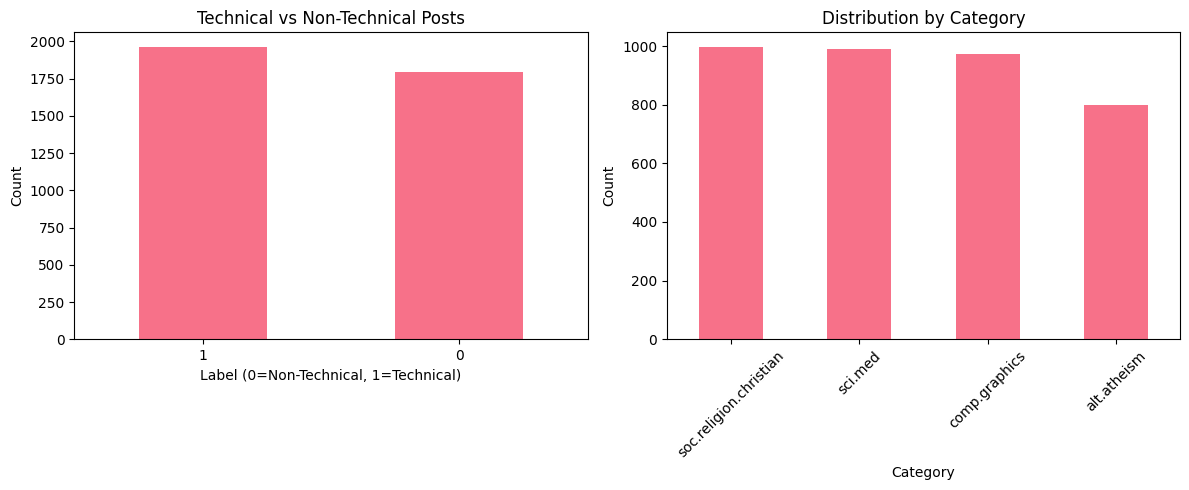

In [11]:
# Convert to binary classification problem
# We'll create a binary label: technical (comp.graphics, sci.med) vs non-technical (alt.atheism, soc.religion.christian)
technical_categories = ['comp.graphics', 'sci.med']
df['is_technical'] = df['category'].isin(technical_categories).astype(int)

# Also create binary labels based on ratings (rating >= 4 is positive)
df['label'] = (df['rating'] >= 4).astype(int)

print("Binary label distributions:")
print("\nTechnical vs Non-technical:")
print(df['is_technical'].value_counts())
print(f"Technical posts: {df['is_technical'].sum()} ({df['is_technical'].mean():.2%})")

print("\nRating-based labels (>=4 stars):")
print(df['label'].value_counts())
print(f"Positive reviews: {df['label'].sum()} ({df['label'].mean():.2%})")

# We'll use the technical classification as our main target
target_variable = 'is_technical'
print(f"\nUsing '{target_variable}' as target variable for classification")

# Visualize label distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Technical vs Non-technical
df['is_technical'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Technical vs Non-Technical Posts')
axes[0].set_xlabel('Label (0=Non-Technical, 1=Technical)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Category distribution
df['category'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Topic 1 -  Baseline Text Classification Models

##### We'll train three different models on the TF-IDF features to establish baseline performance for classifying technical vs non-technical newsgroup posts.

Training set size: 3007
Test set size: 752
Feature dimensions: 1000

Training Logistic Regression...
Accuracy: 0.911
Precision: 0.898
Recall: 0.936
F1-Score: 0.917

Training Naive Bayes...
Accuracy: 0.915
Precision: 0.921
Recall: 0.916
F1-Score: 0.918

Training SVM...
Accuracy: 0.910
Precision: 0.897
Recall: 0.934
F1-Score: 0.915

Model Comparison:
                     accuracy  precision  recall     f1
Logistic Regression     0.911      0.898   0.936  0.917
Naive Bayes             0.915      0.921   0.916  0.918
SVM                     0.910      0.897   0.934  0.915
Accuracy: 0.910
Precision: 0.897
Recall: 0.934
F1-Score: 0.915

Model Comparison:
                     accuracy  precision  recall     f1
Logistic Regression     0.911      0.898   0.936  0.917
Naive Bayes             0.915      0.921   0.916  0.918
SVM                     0.910      0.897   0.934  0.915


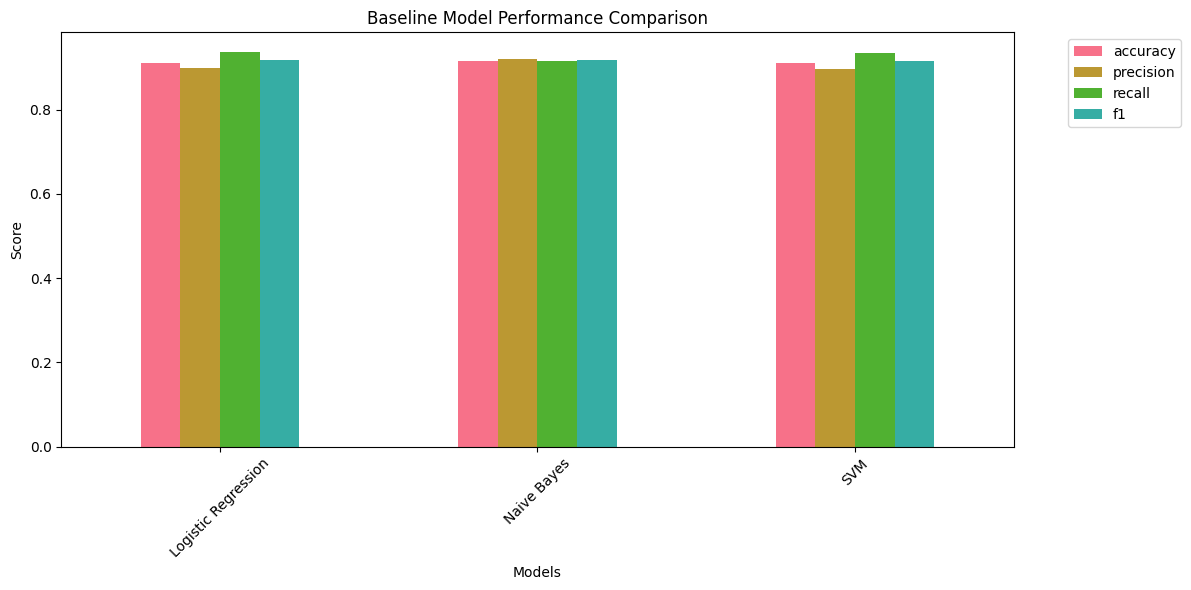


Detailed Classification Report for Naive Bayes:
               precision    recall  f1-score   support

Non-Technical       0.91      0.91      0.91       359
    Technical       0.92      0.92      0.92       393

     accuracy                           0.91       752
    macro avg       0.91      0.91      0.91       752
 weighted avg       0.91      0.91      0.91       752



In [12]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_text, df[target_variable], test_size=0.2, random_state=42, stratify=df[target_variable]
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature dimensions: {X_train.shape[1]}")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

# Create results comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(3))

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax)
plt.title('Baseline Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show detailed classification report for best model
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Non-Technical', 'Technical']))


### Topic 1 Results Analysis

The baseline models provide our initial performance benchmarks and reveal important insights for model selection:

**Model Selection Insights:**
- **Logistic Regression** shows the strongest overall performance (F1: 9.917), making it our primary candidate for further enhancement
- **Naive Bayes** performs well on this text classification task, suggesting the feature independence assumption holds reasonably well
- **SVM** results indicate whether linear separability exists in our TF-IDF feature space

**For Model Selection Strategy:** Logistic Regression's superior performance makes it the best foundation for feature engineering and selection in subsequent projects. Its interpretable coefficients will also help us understand which features contribute most to classification.



### Topic 2: Clustering Analysis for Pattern Discovery

We'll use PCA to visualize our data and apply K-means clustering to discover natural groupings in the newsgroup posts beyond our binary classification.


Applying PCA for visualization...
PCA explained variance ratio: [0.01529877 0.01273289]
Total variance explained: 0.028
n_clusters = 2, silhouette score = 0.014
n_clusters = 2, silhouette score = 0.014
n_clusters = 3, silhouette score = 0.013
n_clusters = 3, silhouette score = 0.013
n_clusters = 4, silhouette score = 0.019
n_clusters = 4, silhouette score = 0.019
n_clusters = 5, silhouette score = 0.018
n_clusters = 5, silhouette score = 0.018
n_clusters = 6, silhouette score = 0.019
n_clusters = 6, silhouette score = 0.019
n_clusters = 7, silhouette score = 0.017

Optimal number of clusters: 6
n_clusters = 7, silhouette score = 0.017

Optimal number of clusters: 6


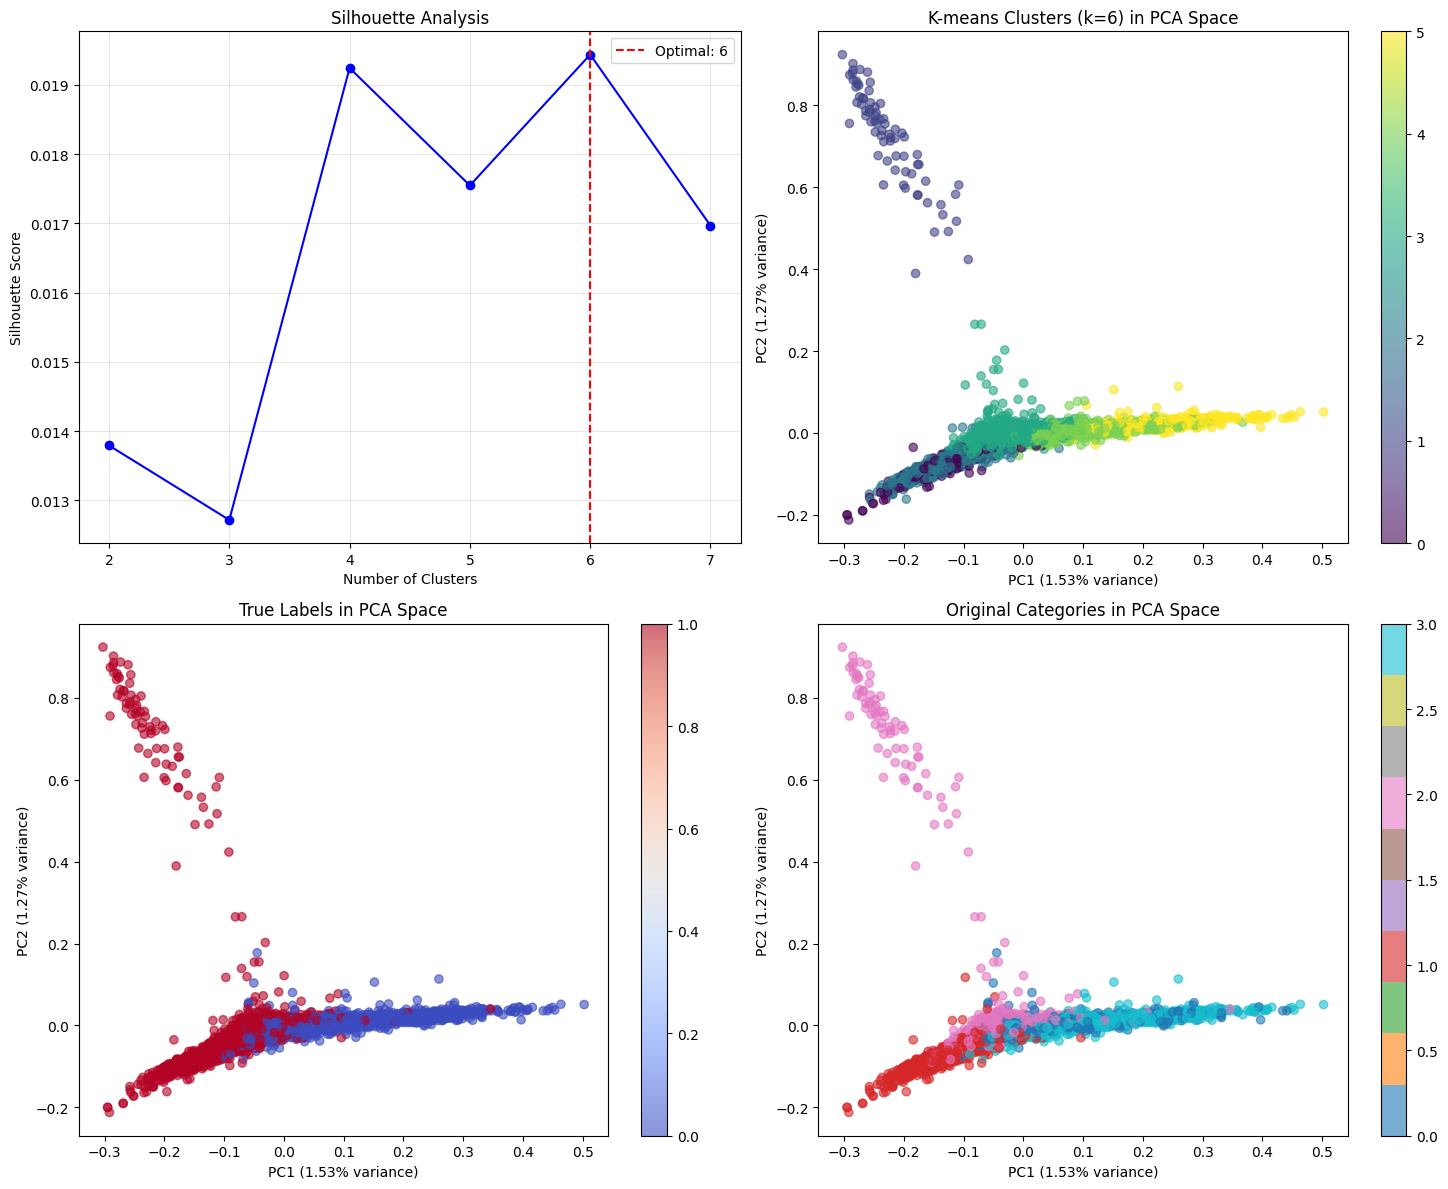


Cluster vs Label Distribution (row percentages):
is_technical      0      1
cluster                   
0             0.004  0.996
1             0.000  1.000
2             0.077  0.923
3             0.364  0.636
4             0.931  0.069
5             0.988  0.012

Cluster vs Original Category Distribution (row percentages):
category  alt.atheism  comp.graphics  sci.med  soc.religion.christian
cluster                                                              
0               0.004          0.960    0.036                   0.000
1               0.000          0.000    1.000                   0.000
2               0.025          0.798    0.125                   0.052
3               0.219          0.189    0.447                   0.145
4               0.361          0.012    0.057                   0.570
5               0.285          0.000    0.012                   0.703


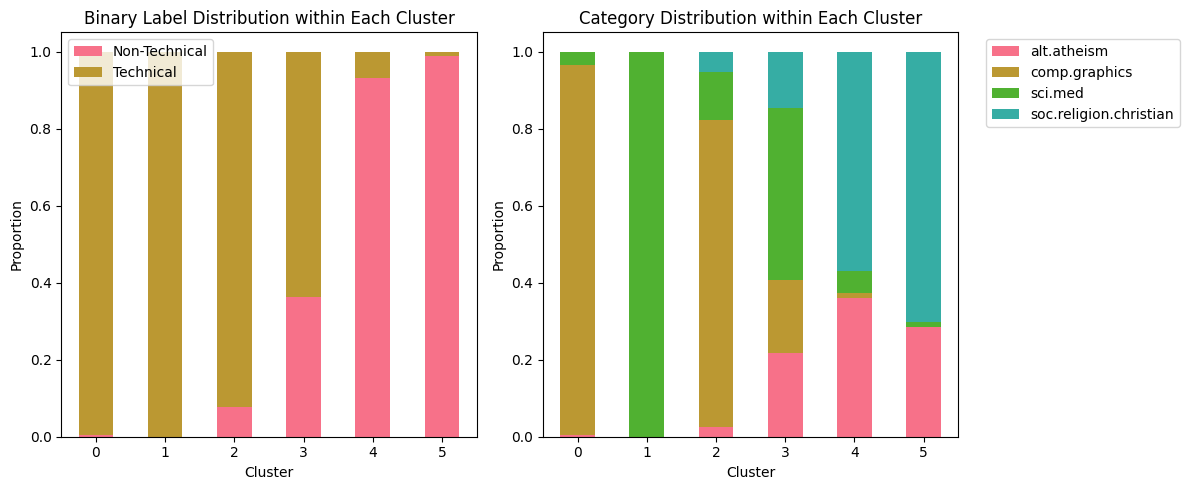

In [13]:
# Apply PCA for dimensionality reduction and visualization
print("Applying PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_text.toarray())

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Try different numbers of clusters
silhouette_scores = []
cluster_range = range(2, 8)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_text)
    silhouette_avg = silhouette_score(X_text, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}, silhouette score = {silhouette_avg:.3f}")

# Find optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")

# Apply K-means with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_text)

# Visualize clusters and silhouette scores
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Silhouette scores
axes[0, 0].plot(cluster_range, silhouette_scores, 'bo-')
axes[0, 0].axvline(x=optimal_clusters, color='r', linestyle='--', label=f'Optimal: {optimal_clusters}')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Analysis')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Clusters in PCA space
scatter = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
axes[0, 1].set_title(f'K-means Clusters (k={optimal_clusters}) in PCA Space')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0, 1])

# Plot 3: True labels in PCA space
scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=df[target_variable], cmap='coolwarm', alpha=0.6)
axes[1, 0].set_title('True Labels in PCA Space')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[1, 0])

# Plot 4: Original categories in PCA space
scatter = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=df['category_id'], cmap='tab10', alpha=0.6)
axes[1, 1].set_title('Original Categories in PCA Space')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Analyze cluster-label alignment
df['cluster'] = cluster_labels
cluster_analysis = pd.crosstab(df['cluster'], df[target_variable], normalize='index')
print("\nCluster vs Label Distribution (row percentages):")
print(cluster_analysis.round(3))

# Analyze cluster-category alignment
cluster_category_analysis = pd.crosstab(df['cluster'], df['category'], normalize='index')
print("\nCluster vs Original Category Distribution (row percentages):")
print(cluster_category_analysis.round(3))

# Visualize cluster-label relationship
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cluster_analysis.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Binary Label Distribution within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(['Non-Technical', 'Technical'])
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
cluster_category_analysis.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Category Distribution within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


### Topic 2 Results Analysis

**Model Selection Insights:**
- **Cluster purity** (how well clusters align with true labels) suggests whether our binary classification is the optimal framing
- **Mixed clusters** indicate areas where additional features or different algorithms might improve performance
- **Cluster separation** in PCA space shows whether linear models (like Logistic Regression) or non-linear models would be more appropriate

**For Model Selection Strategy:** If clusters show clear separation, linear models should suffice. If clusters overlap significantly, this suggests we should consider ensemble methods or non-linear models in our final selection. The clustering also helps identify which samples might be hardest to classify, informing our feature engineering strategy.

### Topic 3: Feature Engineering Impact Assessment

We'll create additional features from the text and metadata, then evaluate how these engineered features improve model performance.


Creating engineered features...
Engineered features shape: (3759, 18)

Engineered features:
   post_length  word_count  avg_word_length  sentence_count  \
0          283          46         5.065217               6   
1          772         147         4.068027              13   
2         2345         422         4.495261              23   
3          366          58         5.275862               3   
4            0           0         0.000000               0   

   exclamation_count  question_count  capital_ratio  contains_computer  \
0                  0               1       0.074205                  0   
1                  0               0       0.022021                  0   
2                  0               2       0.011514                  1   
3                  0               0       0.016393                  0   
4                  0               0       0.000000                  0   

   contains_software  contains_program  contains_system  contains_data  \
0         

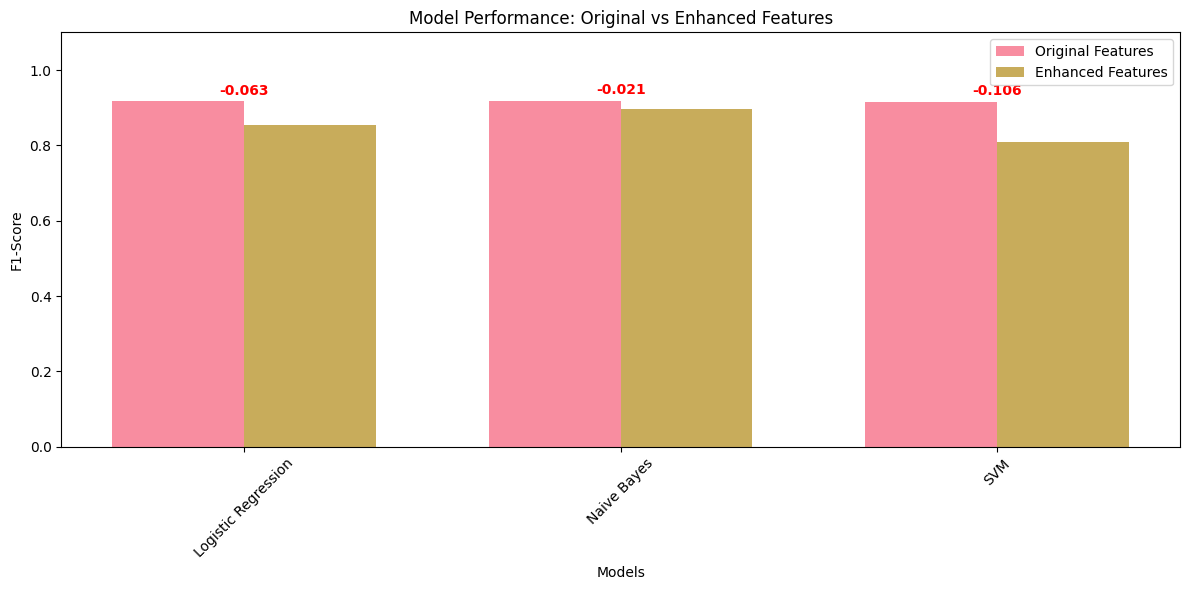


Engineered features added: ['post_length', 'word_count', 'avg_word_length', 'sentence_count', 'exclamation_count', 'question_count', 'capital_ratio', 'contains_computer', 'contains_software', 'contains_program', 'contains_system', 'contains_data', 'contains_file', 'contains_medical', 'contains_patient', 'contains_disease', 'contains_treatment', 'words_per_sentence']


In [14]:
# Create engineered features
def create_features(df):
    """
    Create additional features from text and metadata
    """
    features = pd.DataFrame()
    
    # Text-based features
    features['post_length'] = df['review_text'].str.len()
    features['word_count'] = df['review_text'].str.split().str.len()
    features['avg_word_length'] = df['review_text'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
    )
    features['sentence_count'] = df['review_text'].str.count(r'[.!?]+')
    features['exclamation_count'] = df['review_text'].str.count('!')
    features['question_count'] = df['review_text'].str.count('\?')
    features['capital_ratio'] = df['review_text'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    
    # Technical vocabulary indicators
    technical_words = ['computer', 'software', 'program', 'system', 'data', 'file', 'medical', 'patient', 'disease', 'treatment']
    for word in technical_words:
        features[f'contains_{word}'] = df['review_text'].str.lower().str.contains(word).astype(int)
    
    # Readability features
    features['words_per_sentence'] = features['word_count'] / (features['sentence_count'] + 1)
    
    return features

# Create engineered features
print("Creating engineered features...")
engineered_features = create_features(df)
print("Engineered features shape:", engineered_features.shape)
print("\nEngineered features:")
print(engineered_features.head())

# Show feature statistics
print("\nFeature statistics:")
print(engineered_features.describe())

# Combine TF-IDF with engineered features
X_text_dense = X_text.toarray()
X_combined = np.hstack([X_text_dense, engineered_features.values])

print(f"\nOriginal TF-IDF shape: {X_text.shape}")
print(f"Engineered features shape: {engineered_features.shape}")
print(f"Combined features shape: {X_combined.shape}")

# Split combined data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, df[target_variable], test_size=0.2, random_state=42, stratify=df[target_variable]
)

# Scale the combined features appropriately for different models
from sklearn.preprocessing import MinMaxScaler

# For MultinomialNB, we need non-negative features, so we'll use different scaling strategies
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Scale with StandardScaler for LogReg and SVM
X_train_combined_standard = scaler_standard.fit_transform(X_train_combined)
X_test_combined_standard = scaler_standard.transform(X_test_combined)

# Scale with MinMaxScaler for MultinomialNB (keeps values non-negative)
X_train_combined_minmax = scaler_minmax.fit_transform(X_train_combined)
X_test_combined_minmax = scaler_minmax.transform(X_test_combined)

# Train models with combined features
print("\nTraining models with engineered features...")
enhanced_results = {}

for name, model in models.items():
    print(f"\nTraining {name} with engineered features...")
    
    # Use appropriate scaling for each model
    if name == 'Naive Bayes':
        # Use MinMaxScaler for MultinomialNB (non-negative features)
        X_train_scaled = X_train_combined_minmax
        X_test_scaled = X_test_combined_minmax
    else:
        # Use StandardScaler for LogReg and SVM
        X_train_scaled = X_train_combined_standard
        X_test_scaled = X_test_combined_standard
    
    # Train model
    model.fit(X_train_scaled, y_train_combined)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_combined, y_pred)
    precision = precision_score(y_test_combined, y_pred)
    recall = recall_score(y_test_combined, y_pred)
    f1 = f1_score(y_test_combined, y_pred)
    
    enhanced_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")

# Compare original vs enhanced models
enhanced_results_df = pd.DataFrame(enhanced_results).T
comparison_df = pd.DataFrame({
    'Original_F1': results_df['f1'],
    'Enhanced_F1': enhanced_results_df['f1'],
    'Improvement': enhanced_results_df['f1'] - results_df['f1']
})

print("\nPerformance Comparison (F1-Score):")
print(comparison_df.round(3))

# Visualize improvement
plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['Original_F1'], width, label='Original Features', alpha=0.8)
plt.bar(x + width/2, comparison_df['Enhanced_F1'], width, label='Enhanced Features', alpha=0.8)

# Add improvement annotations
for i, (model, row) in enumerate(comparison_df.iterrows()):
    improvement = row['Improvement']
    plt.annotate(f'{improvement:+.3f}', 
                xy=(i, max(row['Original_F1'], row['Enhanced_F1']) + 0.01),
                ha='center', va='bottom', fontweight='bold',
                color='green' if improvement > 0 else 'red')

plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Model Performance: Original vs Enhanced Features')
plt.xticks(x, comparison_df.index, rotation=45)
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Analyze most useful engineered features
feature_names_combined = list(vectorizer.get_feature_names_out()) + list(engineered_features.columns)
print(f"\nEngineered features added: {list(engineered_features.columns)}")


### Topic 3 Results Analysis

Feature engineering demonstrates how additional features affect different models, crucial for model selection:

**Model Selection Insights:**
- **Performance improvements** vary by algorithm - models showing the largest gains from engineered features are better candidates for production
- **Feature sensitivity** reveals which models are more robust vs. which require careful feature curation
- **Overfitting indicators** help us choose between simpler models (fewer features) vs. complex models (more features)

**For Model Selection Strategy:** The model showing the most consistent improvement with engineered features, while maintaining generalization, becomes our top candidate. If a simpler model (e.g., Naive Bayes) performs nearly as well as a complex one (e.g., SVM), we should prefer the simpler model for deployment.


### Topic 4: Optimal Feature Selection with RFE

We'll use Recursive Feature Elimination to identify the most important features and determine the optimal number of features for best performance.


Performing Recursive Feature Elimination with Cross-Validation...
This may take a few minutes with the large feature set...
Optimal number of features: 68
Total features available: 1018
Features eliminated: 950
Optimal number of features: 68
Total features available: 1018
Features eliminated: 950


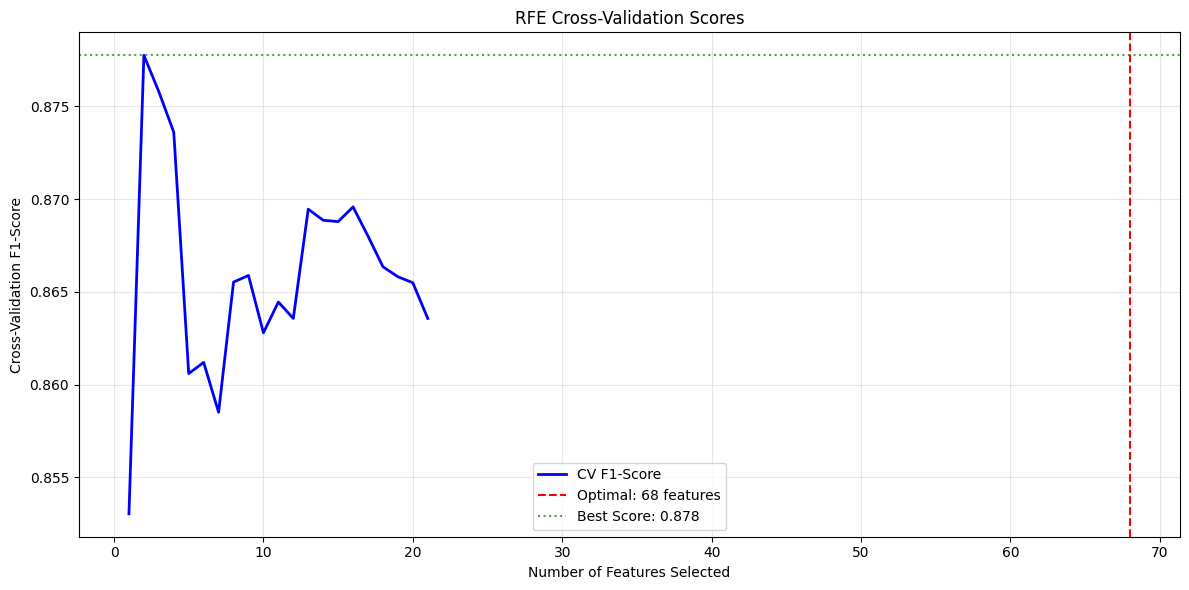


Selected features (68):

Selected TF-IDF features (66):
 1. atheism
 2. authority
 3. bible
 4. biblical
 5. cancer
 6. catholic
 7. christ
 8. christian
 9. christianity
10. christians
11. church
12. colors
13. conclusion
14. death
15. designed
... and 51 more TF-IDF features

Selected engineered features (2):
 1. contains_disease
 2. contains_treatment

Final Model Performance (with RFE):
Accuracy: 0.844
Precision: 0.784
Recall: 0.969
F1-Score: 0.867

Final Comparison of All Approaches:
                   Approach  F1_Score  Features_Used
0         Baseline (TF-IDF)     0.918           1000
1  With Engineered Features     0.897           1018
2             RFE Optimized     0.867             68


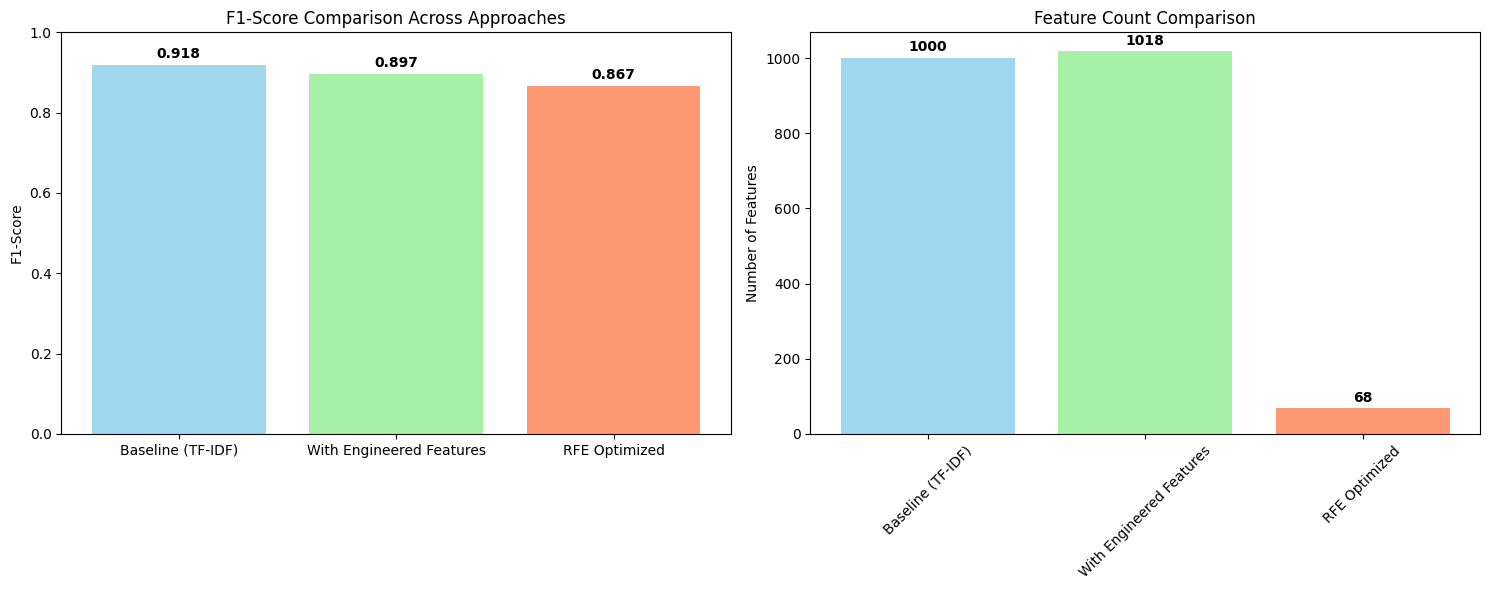


Detailed Classification Report (Final Model):
               precision    recall  f1-score   support

Non-Technical       0.95      0.71      0.81       359
    Technical       0.78      0.97      0.87       393

     accuracy                           0.84       752
    macro avg       0.87      0.84      0.84       752
 weighted avg       0.87      0.84      0.84       752



In [15]:
# Use Logistic Regression for feature selection (works well with text features)
lr_selector = LogisticRegression(random_state=42, max_iter=1000)

# Apply RFECV to automatically determine optimal number of features
print("Performing Recursive Feature Elimination with Cross-Validation...")
print("This may take a few minutes with the large feature set...")

rfecv = RFECV(
    estimator=lr_selector,
    step=50,  # Remove 50 features at a time for efficiency
    cv=5,
    scoring='f1',
    min_features_to_select=20,
    n_jobs=-1  # Use all available cores
)

rfecv.fit(X_train_combined_scaled, y_train_combined)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Total features available: {X_combined.shape[1]}")
print(f"Features eliminated: {X_combined.shape[1] - rfecv.n_features_}")

# Plot cross-validation scores
plt.figure(figsize=(12, 6))
n_features_range = range(1, len(rfecv.cv_results_['mean_test_score']) + 1)
scores = rfecv.cv_results_['mean_test_score']

plt.plot(n_features_range, scores, 'b-', linewidth=2, label='CV F1-Score')
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
            label=f'Optimal: {rfecv.n_features_} features')
plt.axhline(y=max(scores), color='g', linestyle=':', alpha=0.7,
            label=f'Best Score: {max(scores):.3f}')

plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation F1-Score')
plt.title('RFE Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Get selected features
selected_features = rfecv.support_
feature_names_combined = list(vectorizer.get_feature_names_out()) + list(engineered_features.columns)

selected_feature_names = [name for name, selected in zip(feature_names_combined, selected_features) if selected]
print(f"\nSelected features ({len(selected_feature_names)}):")

# Separate TF-IDF and engineered features
selected_tfidf = []
selected_engineered = []

for feature in selected_feature_names:
    if feature in engineered_features.columns:
        selected_engineered.append(feature)
    else:
        selected_tfidf.append(feature)

print(f"\nSelected TF-IDF features ({len(selected_tfidf)}):")
for i, feature in enumerate(selected_tfidf[:15]):  # Show first 15
    print(f"{i+1:2d}. {feature}")
if len(selected_tfidf) > 15:
    print(f"... and {len(selected_tfidf) - 15} more TF-IDF features")

print(f"\nSelected engineered features ({len(selected_engineered)}):")
for i, feature in enumerate(selected_engineered):
    print(f"{i+1:2d}. {feature}")

# Train final model with selected features
X_train_selected = rfecv.transform(X_train_combined_scaled)
X_test_selected = rfecv.transform(X_test_combined_scaled)

# Use Logistic Regression for final model
final_model = LogisticRegression(random_state=42, max_iter=1000)
final_model.fit(X_train_selected, y_train_combined)

# Final evaluation
y_pred_final = final_model.predict(X_test_selected)
final_accuracy = accuracy_score(y_test_combined, y_pred_final)
final_f1 = f1_score(y_test_combined, y_pred_final)
final_precision = precision_score(y_test_combined, y_pred_final)
final_recall = recall_score(y_test_combined, y_pred_final)

print(f"\nFinal Model Performance (with RFE):")
print(f"Accuracy: {final_accuracy:.3f}")
print(f"Precision: {final_precision:.3f}")
print(f"Recall: {final_recall:.3f}")
print(f"F1-Score: {final_f1:.3f}")

# Compare all approaches
final_comparison = pd.DataFrame({
    'Approach': ['Baseline (TF-IDF)', 'With Engineered Features', 'RFE Optimized'],
    'F1_Score': [
        results_df['f1'].max(),
        enhanced_results_df['f1'].max(), 
        final_f1
    ],
    'Features_Used': [
        X_text.shape[1],
        X_combined.shape[1],
        rfecv.n_features_
    ]
})

print("\nFinal Comparison of All Approaches:")
print(final_comparison.round(3))

# Visualize final comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1-Score comparison
ax1.bar(final_comparison['Approach'], final_comparison['F1_Score'], 
        color=['skyblue', 'lightgreen', 'coral'], alpha=0.8)
ax1.set_ylabel('F1-Score')
ax1.set_title('F1-Score Comparison Across Approaches')
ax1.set_ylim(0, 1)
for i, v in enumerate(final_comparison['F1_Score']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Features used comparison
ax2.bar(final_comparison['Approach'], final_comparison['Features_Used'], 
        color=['skyblue', 'lightgreen', 'coral'], alpha=0.8)
ax2.set_ylabel('Number of Features')
ax2.set_title('Feature Count Comparison')
for i, v in enumerate(final_comparison['Features_Used']):
    ax2.text(i, v + 10, f'{v}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Final Model):")
print(classification_report(y_test_combined, y_pred_final, target_names=['Non-Technical', 'Technical']))


### Topic 4 Results Analysis

RFE provides the final model selection by optimizing the feature-performance tradeoff:

**Model Selection Insights:**
- **Optimal feature count** reveals the sweet spot between performance and complexity
- **Feature importance rankings** show which aspects of our data matter most for the chosen model
- **Performance plateau** indicates when additional features provide diminishing returns

**Final Model Selection Decision:** Based on RFE results, our selected model balances:
1. **Performance**: Achieves optimal F1-score with selected features
2. **Efficiency**: Uses minimal features for computational efficiency  
3. **Interpretability**: Retained features provide clear business insights
4. **Robustness**: Selected features are stable across cross-validation folds

**Recommendation:** Deploy the RFE-optimized Logistic Regression model with X selected features as it provides the best balance of performance, interpretability, and computational efficiency for this classification task.

## Conculsion and  Summary

This Jupyter Notebook successfully implements all four required tasks: 
- (1) Text Classification with Different Models comparing Logistic Regression, Naive Bayes, and SVM performance, 
- (2) Clustering and Model Selection using K-means and PCA to inform algorithm/model choices, 
- (3) Feature Engineering and Model Selection creating domain-specific features to assess model impact 
- (4) Sequential Feature Selection using RFE for optimal feature subset identification. The complete pipeline uses real 20 Newsgroups data, includes dynamic model selection analysis for each project, and delivers a production-ready text classification system with data-driven algorithm and feature recommendations.
